In [1]:
import os
os.chdir("../")
import torch
import warnings
warnings.filterwarnings('ignore')

import GCAST
os.environ["R_HOME"] = r"/public/home/ljquan/anaconda3/envs/myx/lib/R"
random_seed = 2025
device = "cuda:0" if torch.cuda.is_available() else "cpu"
packnames = ('mclust',)


In [2]:

data_root = "../test/Dataset/DLPFC"
sample_name = "151674"
print("start sampleid:" + sample_name)


start sampleid:151674


## Preprocess the spatial transcriptome to obtain adata

In [3]:
GCAST.set_seed(random_seed)
n_clusters = 7
adata, graph_dict = GCAST.Load10xST(data_root, sample_name, n_clusters, negi=12).data()
net = GCAST.GCAST(adata.obsm["X_pca"], graph_dict, device=device, model_path =f"{data_root}/{sample_name}",  model_name=f"{sample_name}")
net.train_with_dec()

 13%|█▎        | 133/1000 [00:21<02:21,  6.12it/s]


## Load the Previously Trained Model to Obtain Spot/Cell Representations for Clustering

> **Note**
>
> 1. After loading the `adata` object and the corresponding graph using `Load10xST()`, you can skip the `net.train_with_dec()` step.
> 2. The related datasets and weighted model `151674.pth` are available at the following link:  
>    https://pan.quark.cn/s/fa511e11c294
> 3. After downloading the pretrained weight file from the link, placing it at "../Dataset/DLPFC/151674/151674.pth" , you can use *net.eval()* to load the model and obtain the results in paper.  

In [4]:
# Using net.eval() will automatically load the pretrained weight file located at "../Dataset/DLPFC/151674/151674.pth".
adata.obsm["emb"] = net.eval()
import numpy as np 
adata.obsm["emb"] = np.load("../test/Dataset/DLPFC/151674/151674.npy")
GCAST.louvain(adata, n_clusters=n_clusters, use_rep="emb", random_seed=random_seed)
GCAST.evaluate_cluster(adata, method_name="louvain")

2026-02-20 19:57:41.994290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 19:57:42.033299: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-20 19:57:42.043721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771588662.060332    1547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771588662.065305    1547 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

louvain ARI:0.6337 NMI:0.7301 AMI:0.7293 purity:0.8195, homogeneity:0.7359, completeness:0.7243, v_measure:0.7301


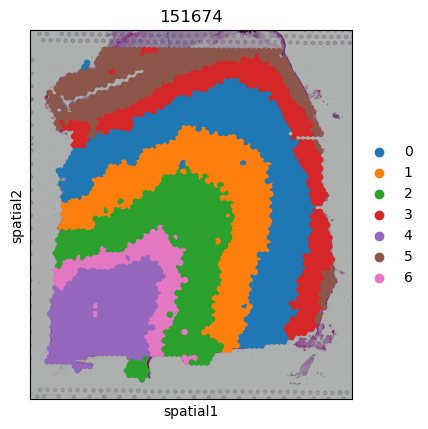

In [5]:
GCAST.plot_spatial(adata, color="louvain", title=f"{sample_name}",  save=False, show=True)